# Generate plots for differential expression simulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from statsmodels.stats.moment_helpers import cov2corr
import string
from collections import OrderedDict
from matplotlib.lines import Line2D

/tmp/ipykernel_692695/2090820009.py:12: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [20]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver', 'lightsteelblue'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [21]:
data_path = '/data_volume/memento/simulation/'

In [22]:
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver', 'lightsteelblue'])


### Read results

In [23]:
# Read anndata object and setup results
adata = sc.read(data_path + 'de/anndata.h5ad')

# Set up results holder
results = OrderedDict()

# Read memento
# results['memento'] = pd.read_csv(data_path + 'de/memento.csv', index_col=0)[['coef', 'pval', 'fdr']]
results['memento'] = pd.read_csv(data_path + 'de/memento_wls.csv', index_col=0)[['coef', 'pval', 'fdr']]

# Read edger
results['edger_lrt'] = pd.read_csv(data_path + 'de/edger_lrt.csv', index_col=0)[['logFC', 'PValue', 'FDR']]
results['edger_qlft'] = pd.read_csv(data_path + 'de/edger_qlft.csv', index_col=0)[['logFC', 'PValue', 'FDR']]



# Read t test
results['t'] = pd.read_csv(data_path + 'de/t.csv', index_col=0)[['coef', 'pval', 'fdr']]

# Get overlapping genes
genes = set(adata.var.index)
for method, result in results.items():
    results[method] = result.join(adata.var[['is_de']],how='inner')
    genes &= set(result.index)
genes = list(genes)
for method, result in results.items():
    results[method] = result.loc[genes]
    results[method].columns = ['coef', 'pval', 'fdr', 'is_de']

### Make power vs FDR curve

memento - fpr: 0.04695177434030937 - tpr : 0.8251417769376181 - thresh : 0.05
edger_lrt - fpr: 0.0 - tpr : 0.1342155009451796 - thresh : 0.05
edger_qlft - fpr: 0.0 - tpr : 0.11720226843100189 - thresh : 0.05
t - fpr: 0.11528662420382166 - tpr : 0.8241965973534972 - thresh : 0.05


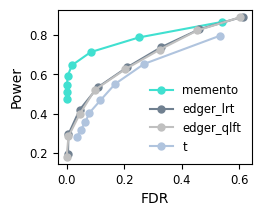

In [29]:
plt.figure(figsize=(2.5, 2))
# Print some statistics
n=8
thresholds = OrderedDict([
    ('memento',np.logspace(-5, -1, n)),
    ('old_memento', np.linspace(0.01, 0.1, n)),
    ('t',np.logspace(-10, -1.5, n)),
    ('edger_lrt',np.linspace(0.1, 0.7, n)),
    ('edger_qlft',np.linspace(0.1, 0.7, n))     
])
check_thresh = 0.05
for method, result in results.items():
    if method == 'old_memento':continue

    tpr = (result.query('is_de')['pval'] < check_thresh).mean()
    fpr = (result.query('~is_de')['pval'] < check_thresh).mean()
    print(f'{method} - fpr: {fpr} - tpr : {tpr} - thresh : {check_thresh}')

    fdr = []
    tpr = []
    sorted_result = result.sort_values('fdr')
    for thresh in thresholds[method]:

        hits = result.query(f'pval < {thresh}')
        fdr.append(1-hits['is_de'].mean())
        tpr.append(hits['is_de'].sum()/result['is_de'].sum())
    plt.plot(fdr, tpr, '-o', label=method, ms=5)
plt.legend(frameon=False, ncol=1, )
plt.ylabel('Power'); plt.xlabel('FDR')
plt.savefig('fdr_tpr_de.pdf', bbox_inches='tight')

memento - fpr: 0.04695177434030937 - tpr : 0.8251417769376181 - thresh : 0.05
edger_lrt - fpr: 0.0 - tpr : 0.1342155009451796 - thresh : 0.05
edger_qlft - fpr: 0.0 - tpr : 0.11720226843100189 - thresh : 0.05
t - fpr: 0.11528662420382166 - tpr : 0.8241965973534972 - thresh : 0.05


Text(0.5, 0, 'FPR')

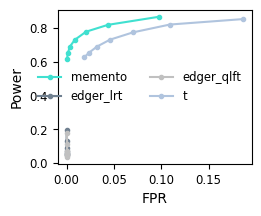

In [25]:
plt.figure(figsize=(2.5, 2))
# Print some statistics
n=8
thresholds = OrderedDict([
    ('memento',np.logspace(-3, -1, n-1)),
    ('memento_wls',np.linspace(0.001, 0.1, n)),
    ('old_memento', np.linspace(0.001, 0.1, n)),

    ('t',np.logspace(-3, -1, n-1)),
    ('edger_lrt',np.logspace(-3, -1, n-1)),
    ('edger_qlft',np.logspace(-3, -1, n-1))     
])
check_thresh = 0.05
for method, result in results.items():

    tpr = (result.query('is_de')['pval'] < check_thresh).mean()
    fpr = (result.query('~is_de')['pval'] < check_thresh).mean()
    print(f'{method} - fpr: {fpr} - tpr : {tpr} - thresh : {check_thresh}')

    fpr = []
    tpr = []
    sorted_result = result.sort_values('fdr')
    for thresh in thresholds[method]:

        hits = result.query(f'pval < {thresh}')
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
        tpr.append(hits['is_de'].sum()/result['is_de'].sum())
    plt.plot(fpr, tpr, '-o', label=method, markersize=3)
plt.legend(frameon=False, ncol=2, )
plt.ylabel('Power'); plt.xlabel('FPR')

### Make calibration curves

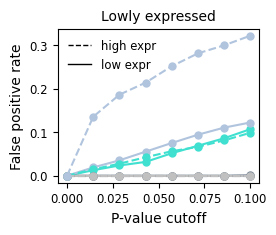

In [30]:
means = pd.DataFrame(adata.X.mean(axis=0).A1, index=adata.var.index)
means.columns=['mean']
plt.figure(figsize=(2.6,2))

# LOW EXPR genes
sig_thresholds = np.linspace(0, 0.1, n)

for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] < np.quantile(result['mean'], 0.1)]
    
    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
plt.ylabel('False positive rate')
plt.xlabel('P-value cutoff')
plt.title('Lowly expressed')

plt.gca().set_prop_cycle(None)

# HIGH EXPR genes
for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] > np.quantile(result['mean'], 0.9)]

    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '--o', markersize=5)
plt.rcParams['legend.handlelength'] = 0
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0, 1.5), ncol=2)
plt.rcParams['legend.handlelength'] = 2
# plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
legend_elements = [Line2D([0], [0], color='k', lw=1, label='high expr', linestyle='--'),
                   Line2D([0], [0], color='k', lw=1, label='low expr')]
plt.legend(handles=legend_elements, frameon=False)


(1204, 5)
(1204, 5)
(1204, 5)
(1204, 5)


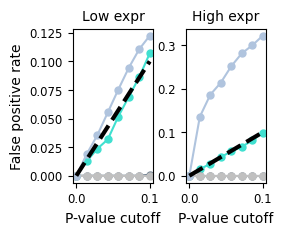

In [36]:
means = pd.DataFrame(adata.X.mean(axis=0).A1, index=adata.var.index)
means.columns=['mean']
plt.figure(figsize=(2.5,2))
plt.subplots_adjust(wspace=0.4)

# LOW EXPR genes
plt.subplot(1, 2, 1);
sig_thresholds = np.linspace(0, 0.1, n)

for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] < np.quantile(result['mean'], 0.1)]
    print(result.shape)
    
    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
plt.ylabel('False positive rate')
plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
plt.title('Low expr')

# HIGH EXPR genes
plt.subplot(1, 2, 2)
for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] > np.quantile(result['mean'], 0.9)]

    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
    # plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0, 1.5), ncol=2)
plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
plt.title('High expr')

plt.savefig('de_calibration.pdf', bbox_inches='tight')